In [ ]:
import fcntl
import uproot
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import concurrent.futures, multiprocessing
ncpu = multiprocessing.cpu_count()
executor = concurrent.futures.ThreadPoolExecutor(ncpu*4)

%matplotlib inline

import timeit
start_time = timeit.default_timer()

# Get data

Select file name and open through `uproot`

In [ ]:
#fname = "/Users/artur/cernbox/HGCAL/cluster/ntuples/hgcalNtuple_qcd_cyl_rad3_n100.root"
#fname = "/Users/artur/cernbox/HGCAL/cluster/ntuples/hgcalNtuple_gamma25_newDefault_n9000.root"
#fname = "/Users/artur/cernbox/HGCAL/cluster/ntuples/hgcalNtuple_ele15_n100_testhelper.root"
#fname = "/Users/artur/cernbox/HGCAL/cluster/ntuples/hgcalNtuple_gamma25_cyl_rad3_n100_PU.root"
#fname = "/Users/artur/cernbox/HGCAL/cluster/ntuples/hgcalNtuple_pi25_n100.root"
#fname = "/Users/artur/cernbox/HGCAL/cluster/ntuples/fromZiheng/CMSSW9304_partGun_PDGid22_x1000_E300.0To300.0_NTUP.root"
fname = "C:/Users/Grasseau/Downloads/hgcalNtuple_electrons_15GeV_n100.root"

tree = uproot.open(fname)["ana/hgc"]

Define variables (branches) to read from the file

In [ ]:
branches = []

branches += ["genpart_gen","genpart_reachedEE","genpart_energy","genpart_eta","genpart_phi", "genpart_pid","genpart_posx","genpart_posy","genpart_posz"]

branches += ["rechit_x", "rechit_y", "rechit_z", "rechit_energy","rechit_layer", 'rechit_flags','rechit_cluster2d',
            'cluster2d_multicluster']

In [ ]:
# Read and cache data
cache = {}
df = tree.pandas.df(branches, cache = cache,executor=executor)

In [ ]:
#%timeit tree.pandas.df(branches, cache = cache,executor=executor)

Look at the first 5 events

In [ ]:
df[:2]

# Look at an event

In [ ]:
event_id = 12

### Create particles data frame

In [ ]:
all_particles = pd.DataFrame({name.replace('genpart_',''):df.loc[event_id,name] for name in branches if 'genpart_' in name })

In [ ]:
# add pt column
all_particles['pt'] = all_particles.energy/np.cosh(all_particles.eta)

In [10]:
all_particles[:5]

,energy,eta,gen,phi,pid,posx,posy,posz,reachedEE,pt
0,57.150143,2.012478,1,-3.093405,11,"[-87.604, -87.8069, -88.1395, -88.3423, -88.67...","[-7.11594, -7.1389, -7.1766, -7.19964, -7.2374...","[320.755, 321.505, 322.735, 323.485, 324.715, ...",2,15.008920
1,57.150143,-2.012478,2,0.048188,-11,"[86.6693, 86.8734, 87.2081, 87.4122, 87.7469, ...","[1.37011, 1.36696, 1.36172, 1.35849, 1.35307, ...","[-320.755, -321.505, -322.735, -323.485, -324....",2,15.008920
2,1.062125,-2.012514,-1,0.045849,22,[],[],[],0,0.278928
3,45.389442,2.013108,-1,-3.091439,22,"[-87.7428, -87.9465, -88.2806, -88.4844, -88.8...","[-4.40191, -4.41213, -4.42891, -4.43913, -4.45...","[320.755, 321.505, 322.735, 323.485, 324.715, ...",2,11.913045
4,8.608773,2.015048,-1,-3.047242,22,"[-87.345, -87.5477, -87.8801, -88.0828, -88.41...","[-7.85375, -7.87293, -7.90438, -7.92356, -7.95...","[320.755, 321.505, 322.735, 323.485, 324.715, ...",2,2.255258


Select particles (the ones with gen > 0 are the initial particles)

In [11]:
selected_part_ind = (all_particles.gen > -2)
selected_part_ind &= (all_particles.reachedEE > 1) 
selected_part_ind &= (all_particles.pt > 5) 
selected_part_ind &= (all_particles.eta > 0) 


particles = all_particles[selected_part_ind]

In [12]:
particles[:5]

,energy,eta,gen,phi,pid,posx,posy,posz,reachedEE,pt
0,57.150143,2.012478,1,-3.093405,11,"[-87.604, -87.8069, -88.1395, -88.3423, -88.67...","[-7.11594, -7.1389, -7.1766, -7.19964, -7.2374...","[320.755, 321.505, 322.735, 323.485, 324.715, ...",2,15.008920
3,45.389442,2.013108,-1,-3.091439,22,"[-87.7428, -87.9465, -88.2806, -88.4844, -88.8...","[-4.40191, -4.41213, -4.42891, -4.43913, -4.45...","[320.755, 321.505, 322.735, 323.485, 324.715, ...",2,11.913045


In [13]:
# print Pt
particles.energy/np.cosh(particles.eta)

0    15.008920
3    11.913045
dtype: float32

In [14]:
min_lay = 0
max_lay = 55

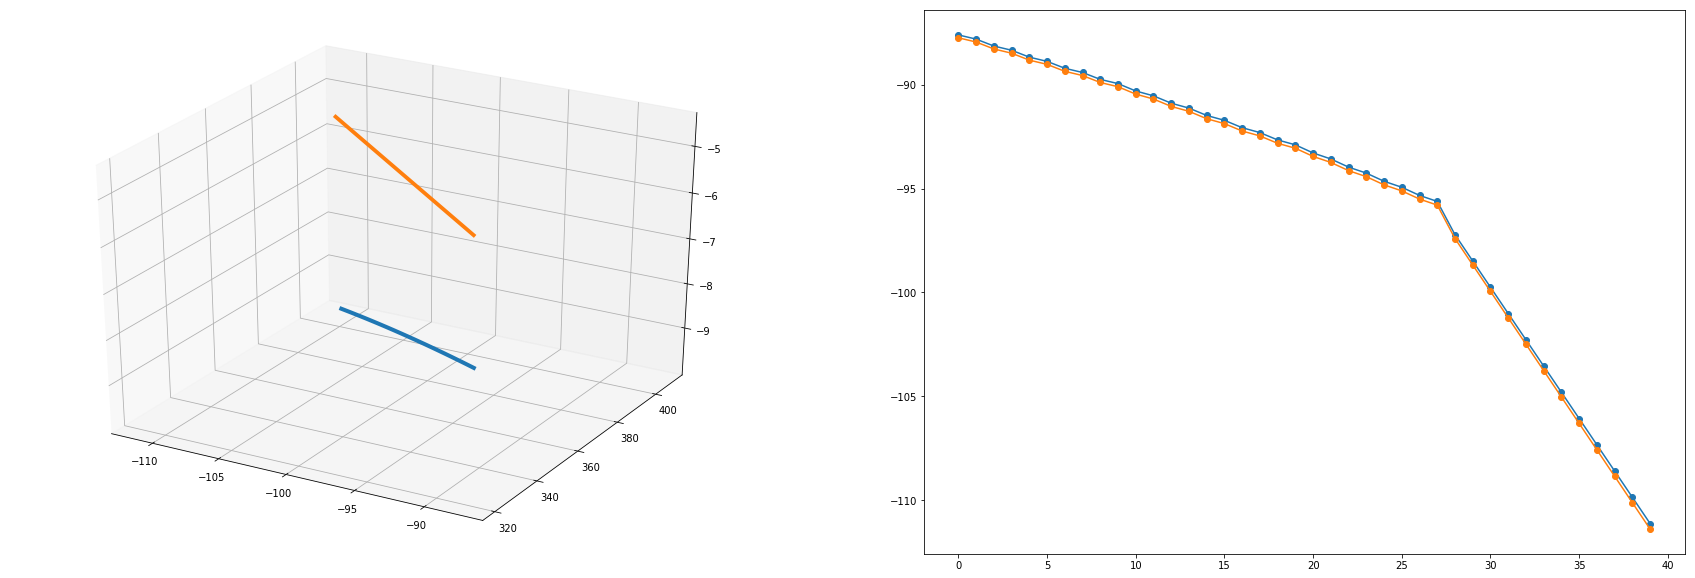

In [15]:
fig = plt.figure(figsize=(30, 10))
ax1 = plt.subplot(121, projection = '3d')
ax2 = plt.subplot(122)

for i_part in particles.index:
    
    posx = particles.loc[i_part,'posx'][min_lay:max_lay]
    posy = particles.loc[i_part,'posy'][min_lay:max_lay]
    posz = particles.loc[i_part,'posz'][min_lay:max_lay]
    ene = particles.loc[i_part,'energy']

    ax1.plot(posx,posz,posy, '-', linewidth = np.log(ene))
    #ax1.scatter(posx,posz,posy,s = enes*10)

    #plt.plot(posz,'o')
    ax2.plot(posx,'-o')

### Create hits data frame

In [16]:
all_hits = pd.DataFrame({name.replace('rechit_',''):df.loc[event_id,name] for name in branches if 'rechit_' in name })

Add multicluster index

In [17]:
cl2d_ind = df.rechit_cluster2d.loc[event_id]

In [18]:
mcl_ind = df.loc[event_id,'cluster2d_multicluster'][cl2d_ind]

Adding 3d cluster index to hits df

In [19]:
all_hits['cluster3d'] = pd.Series(mcl_ind, index=all_hits.index) 

sort columns

In [20]:
all_hits = all_hits.reindex(sorted(all_hits.columns), axis=1)

In [21]:
all_hits[:5]

,cluster2d,cluster3d,energy,flags,layer,x,y,z
0,0,0,0.007053,2,15,-92.775002,-14.608273,335.095001
1,0,0,0.027156,0,15,-93.337280,-5.843304,335.095001
2,0,0,0.022571,0,15,-92.212730,-7.791073,335.095001
3,0,0,0.184799,0,15,-92.212730,-5.843304,335.095001
4,0,0,0.063481,0,15,-93.899551,-4.869427,335.095001


Select hits

In [22]:
selected_hit_ind = (all_hits.flags < 3)
selected_hit_ind &= (all_hits.layer < 59) 
selected_hit_ind &= (all_hits.z > 0) 
selected_hit_ind &= (all_hits.cluster3d < 10000)
selected_hit_ind &= (all_hits.energy > -0.01)

hits = all_hits[selected_hit_ind]

## Plot

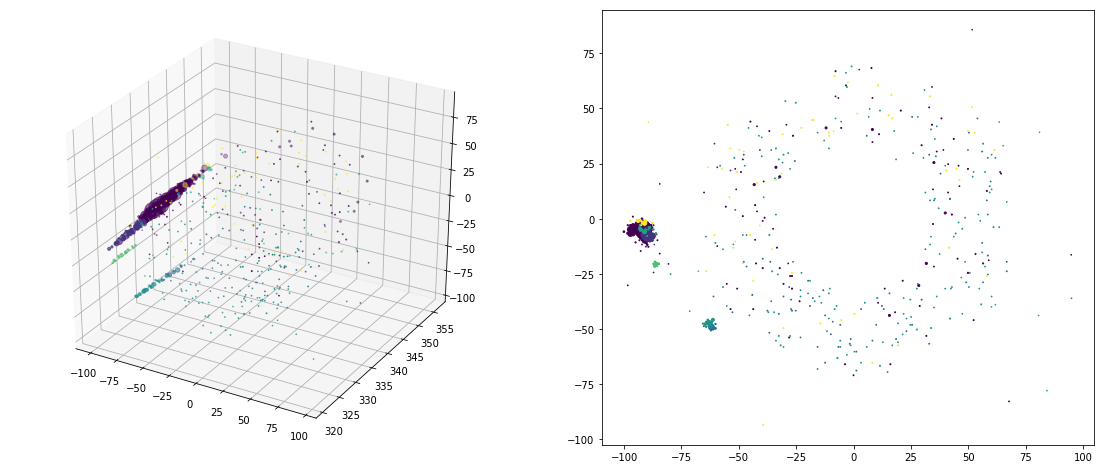

In [23]:
fig = plt.figure(figsize=(30, 8))
ax1 = plt.subplot(131, projection = '3d')
ax2 = plt.subplot(132)
#ax3 = plt.subplot(133)

ax1.scatter(hits.x,abs(hits.z),hits.y, s = hits.energy*100, c = hits.cluster3d)
ax2.scatter(hits.x,hits.y, s = hits.energy*100, c = hits.cluster3d)
#ax2.scatter(abs(hits.z),hits.y, s = hits.energy*100, c = hits.cluster3d)
#ax3.scatter(abs(hits.z),hits.x, s = hits.energy*100, c = hits.cluster3d)

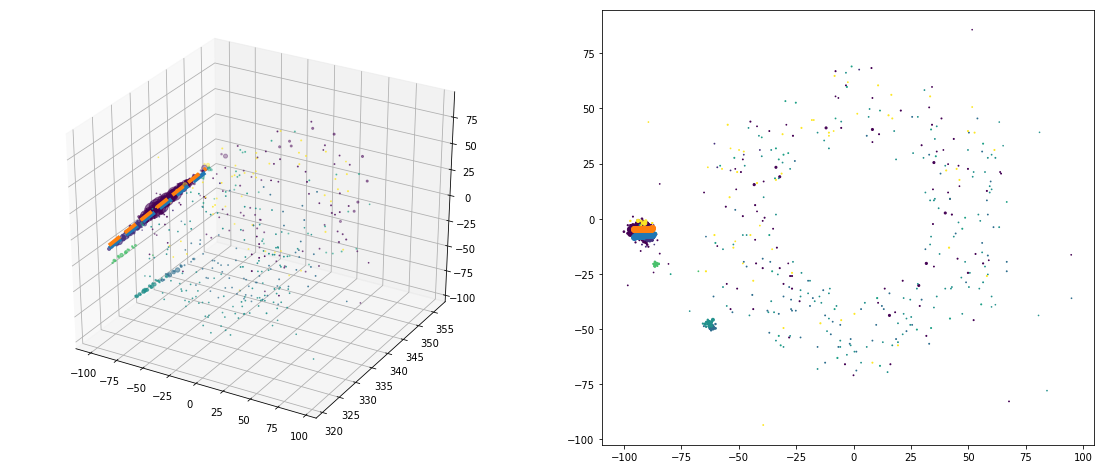

In [24]:
fig = plt.figure(figsize=(30, 8))
ax1 = plt.subplot(131, projection = '3d')
ax2 = plt.subplot(132)
#ax3 = plt.subplot(133)

ax1.scatter(hits.x,abs(hits.z),hits.y, s = hits.energy*100, c = hits.cluster3d)
ax2.scatter(hits.x,hits.y, s = hits.energy*100, c = hits.cluster3d)

max_lay = 28
for i_part in particles.index:
    
    posx = particles.loc[i_part,'posx'][min_lay:max_lay]
    posy = particles.loc[i_part,'posy'][min_lay:max_lay]
    posz = particles.loc[i_part,'posz'][min_lay:max_lay]
    ene = particles.loc[i_part,'energy']

    ax1.plot(posx,posz,posy, '--', linewidth = np.log(ene))
    #ax1.scatter(posx,posz,posy,s = enes*10)

    #plt.plot(posz,'o')
    ax2.plot(posx,posy,'o')

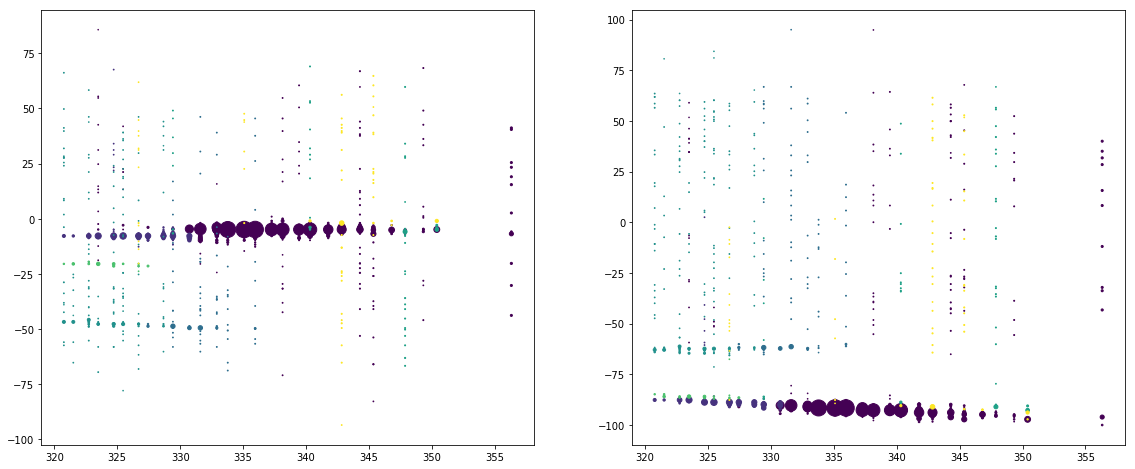

In [25]:
fig = plt.figure(figsize=(30, 8))
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

ax2.scatter(abs(hits.z),hits.y, s = hits.energy*100, c = hits.cluster3d)
ax3.scatter(abs(hits.z),hits.x, s = hits.energy*100, c = hits.cluster3d)
#ax3.scatter(abs(hits.z),hits.x, s = np.log10(hits.energy*1e5), c = hits.cluster3d)

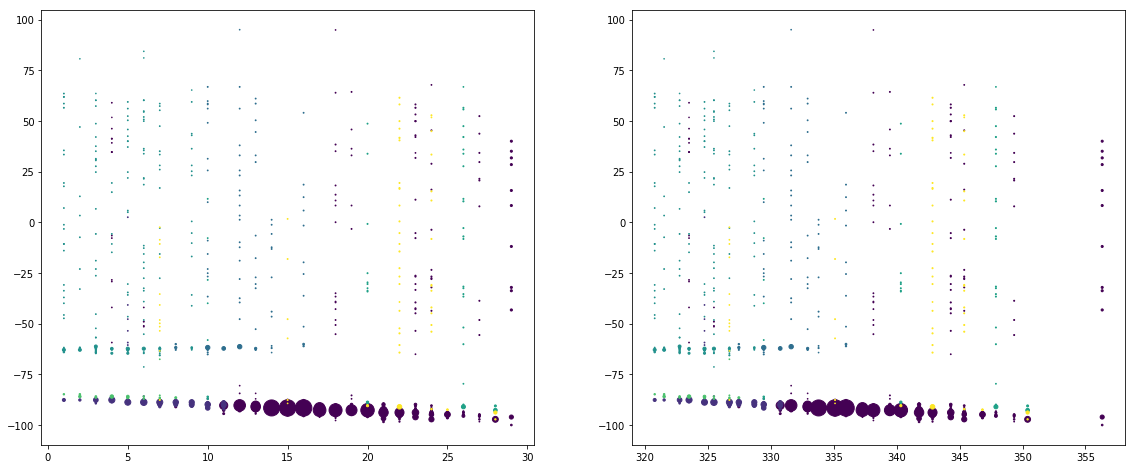

In [26]:
fig = plt.figure(figsize=(30, 8))
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

ax2.scatter(abs(hits.layer),hits.x, s = hits.energy*100, c = hits.cluster3d)
ax3.scatter(abs(hits.z),hits.x, s = hits.energy*100, c = hits.cluster3d)

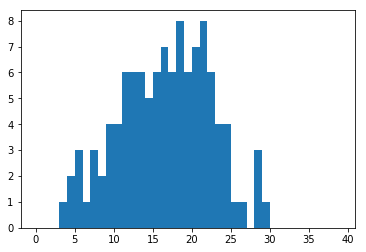

In [27]:
h = plt.hist(hits.layer[hits.energy > 0.1], bins = np.arange(40))

In [28]:
#import seaborn as sns
#sns.set()
#sns.set_style("white")
#h = plt.hist(hits.layer[hits.energy > 0.1], bins = np.arange(40))

In [29]:
print("--- %s seconds ---" % (timeit.default_timer() - start_time))

--- 5.70590400696 seconds ---
